# Customer Segmentation Using RFM and K-Means Clustering

**Objective**: Segment retail customers based on their purchasing behavior using Recency, Frequency, and Monetary (RFM) metrics combined with K-Means clustering.

**Dataset Source**: [UCI Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/online+retail)

**Tools**: Python (Pandas, Scikit-learn, Matplotlib), Jupyter Notebook

---


In [2]:
import pandas as pd

# Load the Excel file
df = pd.read_excel(r'C:\Users\Bhavin Pandya\Downloads\Online Retail.xlsx')

# Show number of rows and columns
print("Shape of data:", df.shape)

# Show first 5 rows
print(df.head())


Shape of data: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
# Data Exploration and Missing Value Check
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)


Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [4]:
# Data Cleaning
# Drop rows where CustomerID is missing
df_clean = df.dropna(subset=['CustomerID'])

# Optional: Also drop rows with missing Description
df_clean = df_clean.dropna(subset=['Description'])

# Convert CustomerID to int (currently float)
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# Confirm shape after cleaning
print("After cleaning:", df_clean.shape)


After cleaning: (406829, 8)


In [5]:
df_clean.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


In [7]:
import datetime as dt

snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


In [8]:
# RFM Scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346,326,2,0.00,1,2,1,121
12347,2,7,4310.00,5,4,5,545
12348,75,4,1797.24,2,3,4,234
12349,19,1,1757.55,4,1,4,414
12350,310,1,334.40,1,1,2,112


In [9]:
from sklearn.preprocessing import StandardScaler

# Select the columns for clustering
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)


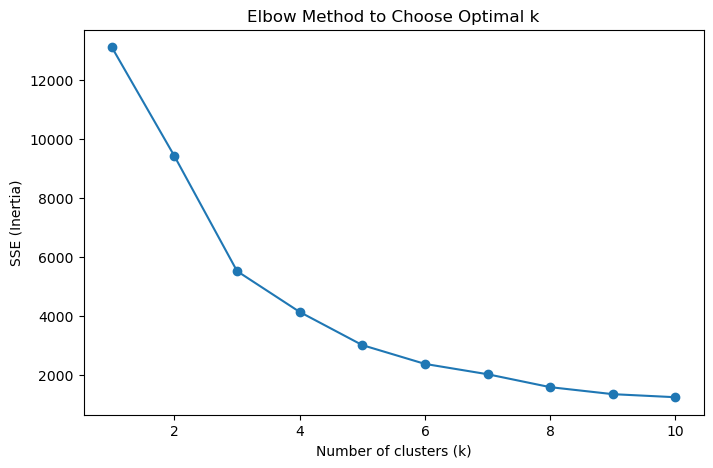

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Try different cluster sizes to find the best one
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method to Choose Optimal k")
plt.show()


In [11]:
# Apply KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(rfm_scaled)

# Add cluster labels to original RFM table
rfm['Cluster'] = kmeans.labels_

# Preview results
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Cluster
CustomerID,,,,,,,,
12346,326,2,0.00,1,2,1,121,1
12347,2,7,4310.00,5,4,5,545,0
12348,75,4,1797.24,2,3,4,234,0
12349,19,1,1757.55,4,1,4,414,0
12350,310,1,334.40,1,1,2,112,1


In [13]:
# Group by cluster and get mean RFM + count of customers
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Add customer count manually
cluster_summary['CustomerCount'] = rfm.groupby('Cluster').size()

# Show result
cluster_summary


,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
0,40.0,5.5,1781.1,3236
1,246.1,1.9,460.4,1108
2,6.2,82.7,52112.1,25
3,3.7,64.7,241136.6,3


In [14]:
def label_cluster(row):
    if row['Cluster'] == 0:
        return 'Champions'
    elif row['Cluster'] == 1:
        return 'At Risk'
    elif row['Cluster'] == 2:
        return 'Loyal Customers'
    elif row['Cluster'] == 3:
        return 'Hibernating'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(label_cluster, axis=1)


In [15]:
# Export Final RFM Segmented Data to Excel

rfm.reset_index().to_excel("Customer_Segmentation_Final.xlsx", index=False)
